In [1]:
import nanomotif as nm
import logging as log
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from scipy.stats import entropy
padding = 12


# Intro

Documentation of considerations in the implementation of the candidate selection. 

The selection is based on the sequences around methylation sites on the contig. At each methylated position, a frame of n posiion on each side of the methylation side is extracted and the index within this subsequence is considered relative to the methylation position (range: -n to n or 0:n*2).

The initial approach for candidate selection is outlined here:

1. Sample random sequences in contig at canonical bases (e.g. A when 6mA i evaluated)
2. Calculate [PSSM](https://cs.rice.edu/~ogilvie/comp571/pssm/) (positional frequencies of bases) for contig sequences
3. Extract sequences in contig at all methylation sites
4. Set motif candidate to canonical base
2. While len(methylations sequences) > minimum sequences 
    - calculate PSSM for methylations sequences
    - Calculate KL-divergence from methylation PSSM to contig PSSM at each position
    - Select position in sequence with highest distance
    - Select most frequent base at this position
    - Add base to motif
    - Score new motif
    - if score > threshold
        - remove seuqences with motif from methylation sequences
        - keep motif
    - else
        - select sequences with motif from methylation sequences

This should grow a motif by incorporation the most informative positions and bases first. 

In [2]:
ec_assembly = nm.load_assembly("../data/ecoli/assembly.polished.fasta")
ec_pileup = nm.load_pileup("../data/ecoli/modkit.pileup.bed")

In [3]:
sequence = ec_assembly.assembly["contig_3"]
ec_temp_pileup = ec_pileup.pileup \
    .filter(pl.col("contig") == "contig_3") \
    .filter(pl.col("mod_type") == "a") \
    .filter(pl.col("fraction_mod") > 0.7) \
    .filter(pl.col("Nvalid_cov") > 5)
methylation_index = ec_temp_pileup \
    .filter(pl.col("strand") == "+") \
    .get_column("position").to_list()

methylation_sequences = nm.seq.EqualLengthDNASet(
    [nm.seq.DNAsequence(sequence[(i - padding):(i + padding + 1)]) for i in methylation_index if (i > padding) and (i < (len(sequence) - padding))]
)
contig_sequences = ec_assembly.assembly["contig_3"].sample_n_at_subsequence(padding, "A", 10000)

DEBUG: Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG: Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG: findfont: score(FontEntry(fname='/user_data/sh/conda_env/modification-binning/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG: findfont: score(FontEntry(fname='/user_data/sh/conda_env/modification-binning/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG: findfont: score(FontEntry(fname='/user_data/sh/conda_env/modification-binning/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf', name='STIXNonUnicode', style='ita

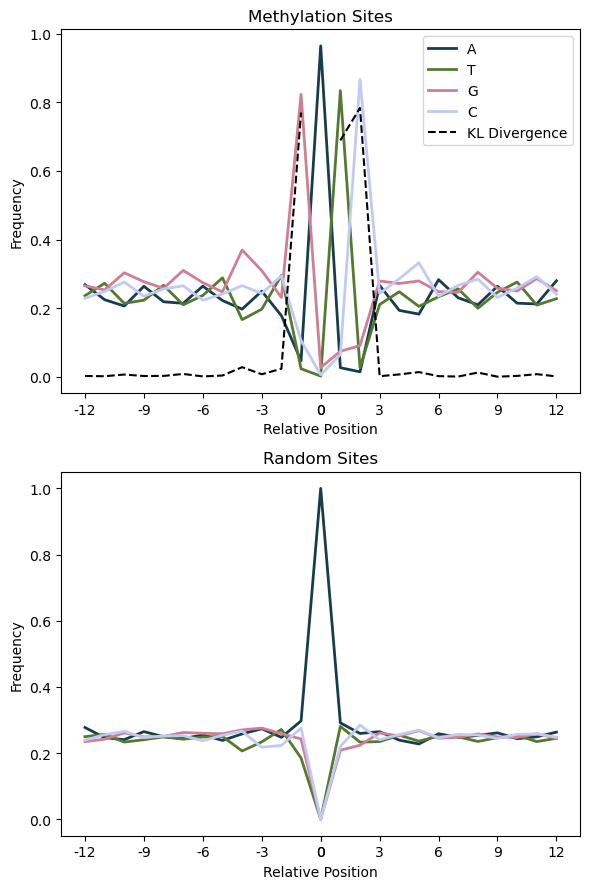

In [4]:

fig, axs = plt.subplots(2, 1, figsize=(6, 9))
methylation_sequences.plot_pssm(axs[0])
axs[0].plot(entropy(methylation_sequences.pssm(), contig_sequences.pssm()), c= "black", label="KL Divergence", ls = "--")
axs[0].legend()
axs[0].set_title("Methylation Sites")
contig_sequences.plot_pssm(axs[1])
axs[1].set_title("Random Sites")
plt.tight_layout()

Here we would pick A at position 0,  as the kl divergence is infinite, as the frequency of non A bases in the contig samples are 0. 

In [ ]:
model_1 = nm.evaluate.score_candidate(ec_temp_pileup, sequence.sequence, "A", padding)
1 - model_1.cdf(0.55)

The score is not high enough so we start over

In [ ]:
active_methylation_sequences = methylation_sequences.get_sequences_with_match("."*padding + "A" + "."*padding)
fig, axs = plt.subplots(1, 1, figsize=(6, 5))
methylation_sequences.plot_pssm(axs)
axs.plot(entropy(active_methylation_sequences.pssm(), contig_sequences.pssm()), c= "black", label="KL Divergence", ls = "--")
axs.legend()
axs.set_title("Methylation Sites")
plt.tight_layout()

We ignore position 0, as it has already been included. Now position -1 has the highest KL-divergence and G is the most frequent base. 

In [ ]:
model_1 = nm.evaluate.score_candidate(ec_temp_pileup, sequence.sequence, "GA", 1)
1 - model_1.cdf(0.55)

We continue

In [ ]:
active_methylation_sequences = active_methylation_sequences.get_sequences_with_match("."*(padding - 1) + "GA" + "."*padding)
fig, axs = plt.subplots(1, 1, figsize=(6, 5))
active_methylation_sequences.plot_pssm(axs)
axs.plot(entropy(active_methylation_sequences.pssm(), contig_sequences.pssm()), c= "black", label="KL Divergence", ls = "--")
axs.legend()
axs.set_title("Methylation Sites")
plt.tight_layout()

The next highed kl i at 2 and is C, we can also see the next is most likely T. Lets add both

In [ ]:
model_2 = nm.evaluate.score_candidate(ec_temp_pileup, sequence.sequence, "GATC", 1)
1 - model_2.cdf(0.2)

Now we keep this and reset without the GATC sequences

In [ ]:
active_methylation_sequences = methylation_sequences.get_sequences_without_match("."*(padding - 1) + "GATC" + "."*(padding-2))
fig, axs = plt.subplots(1, 1, figsize=(6, 5))
active_methylation_sequences.plot_pssm(axs)
axs.plot(entropy(active_methylation_sequences.pssm(), contig_sequences.pssm()), c= "black", label="KL Divergence", ls = "--")
axs.legend()
axs.set_title("Methylation Sites")
plt.tight_layout()

It is pretty messy, lets pick A and C to right of it (highest and second highest KL)

In [ ]:
active_methylation_sequences = active_methylation_sequences.get_sequences_with_match("."*(padding - 0) + "AC" + "."*(padding-1))
fig, axs = plt.subplots(1, 1, figsize=(6, 5))
active_methylation_sequences.plot_pssm(axs)
axs.plot(entropy(active_methylation_sequences.pssm(), contig_sequences.pssm()), c= "black", label="KL Divergence", ls = "--")
axs.legend()
axs.set_title("Methylation Sites")
plt.tight_layout()

We see G and T are enriched at 8 and 9, lets incorporate

In [ ]:
active_methylation_sequences = active_methylation_sequences.get_sequences_with_match("."*(padding - 0) + "AC......GT" + "."*(padding-9))
fig, axs = plt.subplots(1, 1, figsize=(6, 5))
active_methylation_sequences.plot_pssm(axs)
axs.plot(entropy(active_methylation_sequences.pssm(), contig_sequences.pssm()), c= "black", label="KL Divergence", ls = "--")
axs.legend()
axs.set_title("Methylation Sites")
plt.tight_layout()

The next one is G at position 10

In [ ]:
active_methylation_sequences = active_methylation_sequences.get_sequences_with_match("."*(padding - 0) + "AC......GTG" + "."*(padding-10))
fig, axs = plt.subplots(1, 1, figsize=(6, 5))
active_methylation_sequences.plot_pssm(axs)
axs.plot(entropy(active_methylation_sequences.pssm(), contig_sequences.pssm()), c= "black", label="KL Divergence", ls = "--")
axs.legend()
axs.set_title("Methylation Sites")
plt.tight_layout()

From this we can see the final motif forming: AAC......GTGC

In [ ]:
active_methylation_sequences = active_methylation_sequences.get_sequences_with_match("."*(padding - 1) + "AAC......GTGC" + "."*(padding-11))
fig, axs = plt.subplots(1, 1, figsize=(6, 5))
active_methylation_sequences.plot_pssm(axs)
axs.plot(entropy(active_methylation_sequences.pssm(), contig_sequences.pssm()), c= "black", label="KL Divergence", ls = "--")
axs.legend()
axs.set_title("Methylation Sites")

In [ ]:
model_AAC_GTGC = nm.evaluate.score_candidate(ec_temp_pileup, sequence.sequence, "AAC......GTGC", 1)

In [ ]:
model_AAC_GTGC

In [3]:
ec_motifs = nm.evaluate.process_sample(ec_assembly, ec_pileup.pileup, min_read_methylation_fraction = 0.8, cdf_position= 0.60)

INFO: Processing m
INFO: Processing contig_3
DEBUG: ....................C.................... | cdf score: 0.000 | mean: 0.010 | BetaBernoulliModel(alpha=24572, beta=2332182) | max kl: inf
DEBUG: ...................CC.................... | cdf score: 0.000 | mean: 0.048 | BetaBernoulliModel(alpha=22383, beta=439228) | max kl: 1.411
DEBUG: ...................CC..G................. | cdf score: 0.000 | mean: 0.191 | BetaBernoulliModel(alpha=21854, beta=92634) | max kl: 1.364
DEBUG: ...................CC.GG................. | cdf score: 0.000 | mean: 0.570 | BetaBernoulliModel(alpha=23953, beta=18093) | max kl: 1.144
DEBUG: ...................CC[AT]GG................. | cdf score: 1.000 | mean: 0.994 | BetaBernoulliModel(alpha=23953, beta=143) | max kl: 0.768
DEBUG: Saving candidate
DEBUG: ....................C.................... | cdf score: 0.000 | mean: 0.010 | BetaBernoulliModel(alpha=24572, beta=2332182) | max kl: inf
DEBUG: ....................C.A.................. | cdf score: 0.0

In [4]:
ec_motifs

padded_motif,model,cdf_score,contig,mod_type,motif,mod_position
str,object,f64,str,str,str,i64
"""..............…","BetaBernoulliModel(alpha=23953, beta=143)",1.0,"""contig_3""","""m""","""CC[AT]GG""",1
"""..............…","BetaBernoulliModel(alpha=37562, beta=688)",1.0,"""contig_3""","""a""","""GATC""",1
"""..............…","BetaBernoulliModel(alpha=530, beta=67)",1.0,"""contig_3""","""a""","""GCAC......GTT""",2
"""..............…","BetaBernoulliModel(alpha=559, beta=38)",1.0,"""contig_3""","""a""","""AAC......GTGC""",1


DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7f650409ef40>


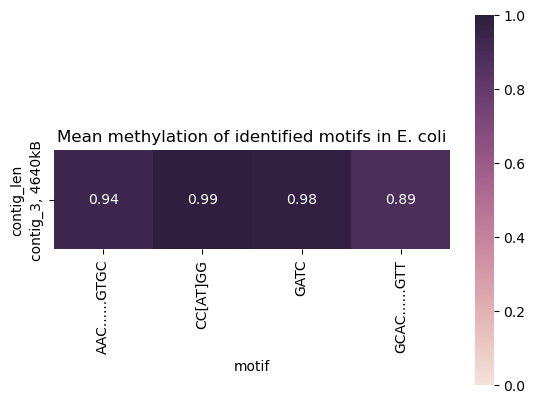

In [6]:
ec_motifs_plot = ec_motifs \
    .with_columns([
        pl.col("model").apply(lambda model: model.mean()).alias("mean"),
        pl.col("contig").apply(lambda contig: f"{contig}, {len(ec_assembly.assembly[contig])/ 1e3:.0f}kB").alias("contig_len"),
    ]).sort("motif", descending = True)
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
heatmap = sns.heatmap(ec_motifs_plot.to_pandas().pivot(values = "mean", index = "contig_len", columns = "motif"), 
                      cmap = cmap, square=True, vmin = 0, vmax = 1, annot = True);
heatmap.set_facecolor('lightgray');
plt.title("Mean methylation of identified motifs in E. coli");
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90);

# M. ruber

In [7]:
mr_assembly = nm.load_assembly("../data/mruber/assembly.polished.fasta")
mr_pileup = nm.load_pileup("../data/mruber/modkit.pileup.bed")

In [8]:
mr_motifs = nm.evaluate.process_sample(mr_assembly, mr_pileup.pileup, min_cdf_score = 0.2, min_read_methylation_fraction = 0.85)

INFO: Processing m
INFO: Processing contig_1
DEBUG: ....................G.................... | cdf score: 0.000 | mean: 0.000 | BetaBernoulliModel(alpha=761, beta=1962484) | max kl: inf
DEBUG: ....................GA................... | cdf score: 0.000 | mean: 0.002 | BetaBernoulliModel(alpha=489, beta=314272) | max kl: 0.522
DEBUG: ..................T.GA................... | cdf score: 0.000 | mean: 0.004 | BetaBernoulliModel(alpha=373, beta=88065) | max kl: 0.839
DEBUG: ..................TCGA................... | cdf score: 0.000 | mean: 0.009 | BetaBernoulliModel(alpha=321, beta=33861) | max kl: 0.712
DEBUG: ..................TCGAG.................. | cdf score: 0.000 | mean: 0.015 | BetaBernoulliModel(alpha=319, beta=20489) | max kl: 1.056
DEBUG: .................CTCGAG.................. | cdf score: 0.000 | mean: 0.021 | BetaBernoulliModel(alpha=312, beta=14754) | max kl: 0.964
DEBUG: .................CTCGAG..C............... | cdf score: 0.000 | mean: 0.029 | BetaBernoulliModel

In [9]:
mr_motifs

padded_motif,model,cdf_score,contig,mod_type,motif,mod_position
str,object,f64,str,str,str,i64
"""..............…","BetaBernoulliModel(alpha=11447, beta=7973)",1.0,"""contig_1""","""a""","""GATC""",1
"""..............…","BetaBernoulliModel(alpha=10706, beta=4360)",1.0,"""contig_1""","""a""","""CTCGAG""",4
"""..............…","BetaBernoulliModel(alpha=4853, beta=1329)",1.0,"""contig_1""","""a""","""AATT""",1
"""..............…","BetaBernoulliModel(alpha=1722, beta=156)",1.0,"""contig_1""","""a""","""GGGAGC""",3
"""..............…","BetaBernoulliModel(alpha=3675, beta=965)",1.0,"""contig_1""","""a""","""TTAA""",3
"""..............…","BetaBernoulliModel(alpha=1015, beta=224)",1.0,"""contig_1""","""a""","""CCA......TGCC""",2
"""..............…","BetaBernoulliModel(alpha=119, beta=53)",0.999933,"""contig_1""","""a""","""GGCAGC....TGG""",4
"""..............…","BetaBernoulliModel(alpha=1216, beta=23)",1.0,"""contig_1""","""a""","""GGCA......TGG""",3


DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7f64ff691eb0>


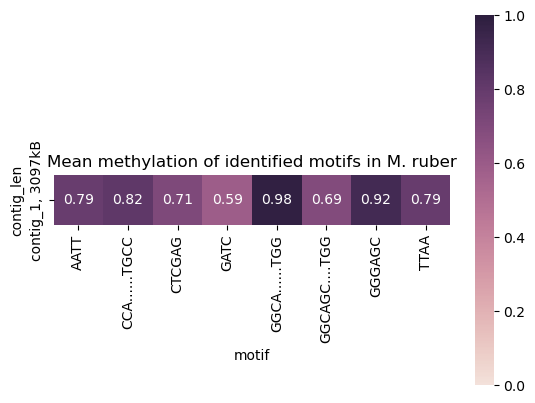

In [10]:
mr_motifs_plot = mr_motifs \
    .with_columns([
        pl.col("model").apply(lambda model: model.mean()).alias("mean"),
        pl.col("contig").apply(lambda contig: f"{contig}, {len(mr_assembly.assembly[contig])/ 1e3:.0f}kB").alias("contig_len"),
    ]).sort("motif", descending = True)
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
heatmap = sns.heatmap(mr_motifs_plot.to_pandas().pivot(values = "mean", index = "contig_len", columns = "motif"), 
                      cmap = cmap, square=True, vmin = 0, vmax = 1, annot = True);
heatmap.set_facecolor('lightgray');
plt.title("Mean methylation of identified motifs in M. ruber");

# Geobacillus

In [26]:
gb_assembly = nm.load_assembly("../data/geobacillus/assembly.polished.fasta")
gb_pileup = nm.load_pileup("../data/geobacillus/modkit.pileup.bed")

In [35]:
contigs_with_mods = gb_pileup.pileup.groupby("contig") \
    .agg(pl.count()) \
    .filter(pl.col("count") > 5000000) \
    .get_column("contig").to_list()
contigs_to_process = [contig for contig in gb_assembly.assembly.keys() if contig in contigs_with_mods]
gb_pileup.pileup.filter(pl.col("contig").is_in(contigs_with_mods))

contig,position,mod_type,strand,fraction_mod,Nvalid_cov
str,i64,str,str,f64,i64
"""contig_1""",0,"""a""","""+""",0.0172,58
"""contig_1""",1,"""a""","""+""",0.0185,54
"""contig_1""",2,"""a""","""-""",0.0161,62
"""contig_1""",3,"""m""","""-""",0.0,64
"""contig_1""",4,"""m""","""+""",0.0,1
"""contig_1""",4,"""a""","""-""",0.0317,63
"""contig_1""",5,"""a""","""-""",0.0161,62
"""contig_1""",6,"""m""","""+""",0.0172,58
"""contig_1""",6,"""a""","""-""",0.0,1


In [3]:
gb_motifs = nm.evaluate.process_sample(gb_assembly, gb_pileup.pileup.filter(pl.col("mod_type") == "a"), max_candidate_size = 28)

INFO: Processing a
INFO: Processing contig_3
DEBUG: ..............A.............. | cdf score: 0.000 | mean: 0.017 | BetaBernoulliModel(alpha=807, beta=45887) | max kl: inf
DEBUG: ..............A.C............ | cdf score: 0.000 | mean: 0.073 | BetaBernoulliModel(alpha=686, beta=8741) | max kl: 0.974
DEBUG: .............GA.C............ | cdf score: 0.000 | mean: 0.293 | BetaBernoulliModel(alpha=603, beta=1454) | max kl: 1.000
DEBUG: .............GATC............ | cdf score: 1.000 | mean: 0.849 | BetaBernoulliModel(alpha=603, beta=107) | max kl: 1.232
DEBUG: Saving candidate
DEBUG: ..............A.............. | cdf score: 0.000 | mean: 0.017 | BetaBernoulliModel(alpha=807, beta=45887) | max kl: inf
DEBUG: ...........C..A.............. | cdf score: 0.000 | mean: 0.029 | BetaBernoulliModel(alpha=223, beta=7532) | max kl: 0.595
DEBUG: ..........CC..A.............. | cdf score: 0.000 | mean: 0.052 | BetaBernoulliModel(alpha=100, beta=1808) | max kl: 0.602
DEBUG: ..........CC..AT........

In [4]:
gb_motifs

padded_motif,model,cdf_score,contig,mod_type,motif,mod_position
str,object,f64,str,str,str,i64
""".............G…","BetaBernoulliModel(alpha=603, beta=107)",1.0,"""contig_3""","""a""","""GATC""",1
"""..........CCAA…","BetaBernoulliModel(alpha=79, beta=3)",1.0,"""contig_3""","""a""","""CCAAAT""",4
""".........GA.GA…","BetaBernoulliModel(alpha=33, beta=5)",0.999992,"""contig_3""","""a""","""GA.GAAGC""",5
"""..........ACCC…","BetaBernoulliModel(alpha=49, beta=18)",0.998995,"""contig_3""","""a""","""ACCCA""",4
""".........GG.GA…","BetaBernoulliModel(alpha=25, beta=10)",0.979011,"""contig_3""","""a""","""GG.GAAG[TC]""",5
""".............G…","BetaBernoulliModel(alpha=525, beta=237)",1.0,"""contig_2""","""a""","""GATC""",1
"""..........ACCC…","BetaBernoulliModel(alpha=58, beta=36)",0.907768,"""contig_2""","""a""","""ACCCA""",4
"""..........CCAA…","BetaBernoulliModel(alpha=66, beta=12)",1.0,"""contig_2""","""a""","""CCAAAT""",4
""".............G…","BetaBernoulliModel(alpha=23104, beta=3334)",1.0,"""contig_1""","""a""","""GATC""",1


DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7f37ec8ecfd0>


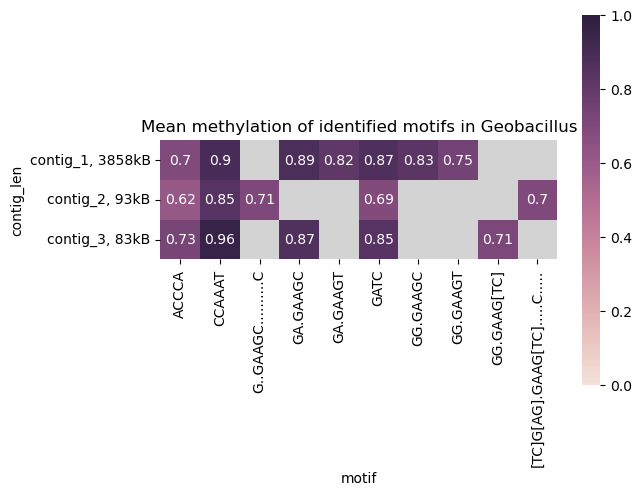

In [9]:
log.basicConfig(level=log.INFO);
gb_motifs_plot = gb_motifs \
    .with_columns([
        pl.col("model").apply(lambda model: model.mean()).alias("mean"),
        pl.col("contig").apply(lambda contig: f"{contig}, {len(gb_assembly.assembly[contig])/ 1e3:.0f}kB").alias("contig_len"),
    ]).sort("motif", descending = True)
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
heatmap = sns.heatmap(gb_motifs_plot.to_pandas().pivot(values = "mean", index = "contig_len", columns = "motif"), 
                      cmap = cmap, square=True, vmin = 0, vmax = 1, annot = True);
heatmap.set_facecolor('lightgray')
plt.title("Mean methylation of identified motifs in Geobacillus");

# E. coli -dcm/-dam

In [2]:
ecneg_assembly = nm.load_assembly("../data/ecoli_neg/assembly.polished.fasta")
ecneg_pileup = nm.load_pileup("../data/ecoli_neg/modkit.pileup.bed")

In [5]:
ecneg_assembly.assembly.keys()

dict_keys(['contig_1'])

In [17]:
ecneg_motifs = nm.evaluate.process_sample(ecneg_assembly, ecneg_pileup.pileup, min_read_methylation_fraction = 0.4)

INFO: Processing a
INFO: Processing contig_1
DEBUG: ....................G.................... | cdf score: 0.000 | mean: 0.005 | BetaBernoulliModel(alpha=12569, beta=2338351) | max kl: inf
DEBUG: ...................CG.................... | cdf score: 0.000 | mean: 0.012 | BetaBernoulliModel(alpha=8222, beta=683830) | max kl: 0.316
DEBUG: ...................CGC................... | cdf score: 0.000 | mean: 0.014 | BetaBernoulliModel(alpha=2908, beta=209607) | max kl: 0.226
DEBUG: ...................CGCG.................. | cdf score: 0.000 | mean: 0.029 | BetaBernoulliModel(alpha=1509, beta=50877) | max kl: 0.195
DEBUG: .................G.CGCG.................. | cdf score: 0.000 | mean: 0.044 | BetaBernoulliModel(alpha=695, beta=14991) | max kl: 0.116
DEBUG: .................GGCGCG.................. | cdf score: 0.000 | mean: 0.065 | BetaBernoulliModel(alpha=364, beta=5232) | max kl: 0.172
DEBUG: ................GGGCGCG.................. | cdf score: 0.000 | mean: 0.144 | BetaBernoulli

In [18]:
ecneg_motifs


motif,mod_position,mod_type,cdf_score
f32,f32,f32,f32


# Combining results

In [110]:
assemblies = {
    "ecoli": ec_assembly,
    "ecoli_neg": ecneg_assembly,
    "gb": gb_assembly,
    "mr": mr_assembly
}
pileups = {
    "ecoli": ec_pileup,
    "ecoli_neg": ecneg_pileup,
    "gb": gb_pileup,
    "mr": mr_pileup
}

In [132]:
all_motifs = pl.concat([ec_motifs, mr_motifs, gb_motifs])
all_motifs_scored = {
    "sample":[],
    "contig":[],
    "type":[],
    "motif":[],
    "model":[],
    "mean":[],
    "score":[]
}
for sample, assembly in assemblies.items():
    print(sample)
    for contig, contig_sequence in assembly.assembly.items():
        for row in all_motifs.rows():
            model = nm.evaluate.score_candidate(
                pileups[sample].pileup.filter(pl.col("contig") == contig).filter(pl.col("mod_type") == row[-3]) \
                    .filter(pl.col("Nvalid_cov") > 5) \
                    .filter(pl.col("fraction_mod") > 0.8) ,
                contig_sequence.sequence,
                row[-2],
                row[-1]
            )
            all_motifs_scored["sample"].append(sample)
            all_motifs_scored["contig"].append(contig)
            all_motifs_scored["motif"].append(row[-2])
            all_motifs_scored["model"].append(model)
            all_motifs_scored["mean"].append(model.mean())
            all_motifs_scored["score"].append(1 - model.cdf(0.55))
            all_motifs_scored["type"].append(row[-3])
            print(row[-2])
            print(row[-1])

            print(model)
all_motifs_scored

ecoli
CC[AT]GG
1
BetaBernoulliModel(alpha=23953, beta=143)
GATC
1
BetaBernoulliModel(alpha=37562, beta=688)
GCAC......GTT
2
BetaBernoulliModel(alpha=530, beta=67)
AAC......GTGC
1
BetaBernoulliModel(alpha=559, beta=38)
GATC
1
BetaBernoulliModel(alpha=37562, beta=688)
CTCGAG
4
BetaBernoulliModel(alpha=1, beta=357)
AATT
1
BetaBernoulliModel(alpha=26, beta=39290)
GGGAGC
3
BetaBernoulliModel(alpha=5, beta=931)
TTAA
3
BetaBernoulliModel(alpha=77, beta=42339)
CCA......TGCC
2
BetaBernoulliModel(alpha=11, beta=1027)
GGCAGC....TGG
4
BetaBernoulliModel(alpha=1, beta=77)
GGCA......TGG
3
BetaBernoulliModel(alpha=3, beta=1035)
GATC
1
BetaBernoulliModel(alpha=37562, beta=688)
CCAAAT
4
BetaBernoulliModel(alpha=1, beta=1648)
GA.GAAGC
5
BetaBernoulliModel(alpha=2, beta=1062)
ACCCA
4
BetaBernoulliModel(alpha=21, beta=7114)
GG.GAAG[TC]
5
BetaBernoulliModel(alpha=6, beta=1589)
GGAGGAAGC.T
7
BetaBernoulliModel(alpha=1, beta=9)
GA.GAAGT
5
BetaBernoulliModel(alpha=2, beta=930)
GATC
1
BetaBernoulliModel(alpha=

{'sample': ['ecoli',
  'ecoli',
  'ecoli',
  'ecoli',
  'ecoli',
  'ecoli',
  'ecoli',
  'ecoli',
  'ecoli',
  'ecoli',
  'ecoli',
  'ecoli',
  'ecoli',
  'ecoli',
  'ecoli',
  'ecoli',
  'ecoli',
  'ecoli',
  'ecoli',
  'ecoli',
  'ecoli',
  'ecoli',
  'ecoli',
  'ecoli',
  'ecoli',
  'ecoli',
  'ecoli',
  'ecoli',
  'ecoli',
  'ecoli',
  'ecoli',
  'ecoli',
  'ecoli',
  'ecoli_neg',
  'ecoli_neg',
  'ecoli_neg',
  'ecoli_neg',
  'ecoli_neg',
  'ecoli_neg',
  'ecoli_neg',
  'ecoli_neg',
  'ecoli_neg',
  'ecoli_neg',
  'ecoli_neg',
  'ecoli_neg',
  'ecoli_neg',
  'ecoli_neg',
  'ecoli_neg',
  'ecoli_neg',
  'ecoli_neg',
  'ecoli_neg',
  'ecoli_neg',
  'ecoli_neg',
  'ecoli_neg',
  'ecoli_neg',
  'ecoli_neg',
  'ecoli_neg',
  'ecoli_neg',
  'ecoli_neg',
  'ecoli_neg',
  'ecoli_neg',
  'ecoli_neg',
  'ecoli_neg',
  'ecoli_neg',
  'ecoli_neg',
  'ecoli_neg',
  'gb',
  'gb',
  'gb',
  'gb',
  'gb',
  'gb',
  'gb',
  'gb',
  'gb',
  'gb',
  'gb',
  'gb',
  'gb',
  'gb',
  'gb',
  'gb',
  'g

In [140]:
motifs_all_samples = pl.DataFrame(all_motifs_scored) \
.with_columns(
    (pl.col("sample") + ", " + pl.col("contig").str.replace("contig_", "c")).alias("id"),
    (pl.col("motif") + ", " + pl.col("type")).alias("motif_mod_type")
)
motifs_all_samples

sample,contig,type,motif,model,mean,score,id,motif_mod_type
str,str,str,str,object,f64,f64,str,str
"""ecoli""","""contig_3""","""m""","""CC[AT]GG""","BetaBernoulliModel(alpha=23953, beta=143)",0.994065,1.0,"""ecoli, c3""","""CC[AT]GG, m"""
"""ecoli""","""contig_3""","""a""","""GATC""","BetaBernoulliModel(alpha=37562, beta=688)",0.982013,1.0,"""ecoli, c3""","""GATC, a"""
"""ecoli""","""contig_3""","""a""","""GCAC......GTT""","BetaBernoulliModel(alpha=530, beta=67)",0.887772,1.0,"""ecoli, c3""","""GCAC......GTT,…"
"""ecoli""","""contig_3""","""a""","""AAC......GTGC""","BetaBernoulliModel(alpha=559, beta=38)",0.936348,1.0,"""ecoli, c3""","""AAC......GTGC,…"
"""ecoli""","""contig_3""","""a""","""GATC""","BetaBernoulliModel(alpha=37562, beta=688)",0.982013,1.0,"""ecoli, c3""","""GATC, a"""
"""ecoli""","""contig_3""","""a""","""CTCGAG""","BetaBernoulliModel(alpha=1, beta=357)",0.002793,0.0,"""ecoli, c3""","""CTCGAG, a"""
"""ecoli""","""contig_3""","""a""","""AATT""","BetaBernoulliModel(alpha=26, beta=39290)",0.000661,0.0,"""ecoli, c3""","""AATT, a"""
"""ecoli""","""contig_3""","""a""","""GGGAGC""","BetaBernoulliModel(alpha=5, beta=931)",0.005342,0.0,"""ecoli, c3""","""GGGAGC, a"""
"""ecoli""","""contig_3""","""a""","""TTAA""","BetaBernoulliModel(alpha=77, beta=42339)",0.001815,0.0,"""ecoli, c3""","""TTAA, a"""


motif_mod_type,"AAC......GTGC, a","AATT, a","ACCCA, a","CCA......TGCC, a","CCAAAT, a","CC[AT]GG, m","CTCGAG, a","GA.GAAGC, a","GA.GAAGT, a","GA.GAAG[TC], a",...,"GCAC......GTT, a","GG.GAAGC, a","GG.GAAGT, a","GG.GAAG[TC], a","GGAGGAAGC.T, a","GGCA......TGG, a","GGCAGC....TGG, a","GGGAGC, a","T....G.G[AG].[AG]AA[TG]CA..G.....AG, a","TTAA, a"
id,,,,,,,,,,,,,,,,,,,,,
"ecoli, c3",1.000000,0.0,0.000000,0.000000,0.0,1.0,0.000000e+00,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,7.566806e-04,0.000000,0.000000e+00,0.000000e+00,0.018453,0.0
"ecoli_neg, c1",0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,7.566806e-04,0.000000,0.000000e+00,0.000000e+00,0.018453,0.0
"gb, c1",0.000000,0.0,1.000000,0.000000,1.0,0.0,0.000000e+00,1.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,9.488242e-04,0.000000,3.947986e-11,0.000000e+00,0.202500,0.0
"gb, c2",0.003737,0.0,0.907768,0.000757,1.0,0.0,7.566806e-04,0.989698,0.994527,0.999701,...,0.003737,0.987405,0.907079,0.995973,4.500000e-01,0.000757,4.500000e-01,1.272368e-06,0.949672,0.0
"gb, c3",0.003737,0.0,0.998995,0.000341,1.0,0.0,2.576545e-07,0.999992,0.993380,1.000000,...,0.003737,0.991664,0.573194,0.979011,9.723194e-01,0.000341,4.500000e-01,4.754450e-09,0.450000,0.0
"mr, c1",0.000000,1.0,0.000000,1.000000,0.0,0.0,1.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,4.332493e-10,1.000000,9.999999e-01,1.000000e+00,0.091125,1.0


DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7f6384bfba90>


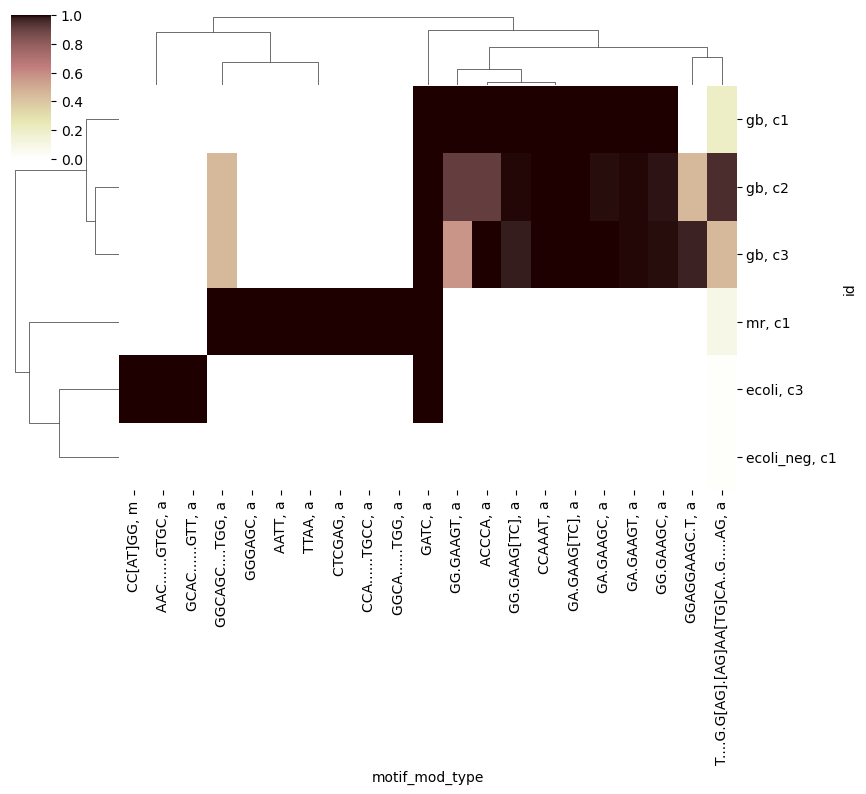

In [165]:
cmap = sns.cubehelix_palette(as_cmap=True, light=.8)
heatmap = sns.clustermap(
    motifs_all_samples.to_pandas().reset_index().drop_duplicates(subset=['id', 'motif_mod_type'], keep='last').pivot(values = "score", index = "id", columns = "motif_mod_type"), 
    cmap = "pink_r", vmin = 0, vmax = 1,
    row_cluster=True, col_cluster=True, dendrogram_ratio=0.15, figsize = (8, 8));
heatmap.ax_heatmap.yaxis.set_ticklabels(heatmap.ax_heatmap.yaxis.get_ticklabels(), rotation=0, ha='left');